In [1]:
#copy this set_mode_left to the core/solvers.py

def set_state_left(self, index, subsystem):
    """
    Set state vector to the specified eigenmode.

    Parameters
    ----------
    index : int
        Index of desired eigenmode.
    subsystem : Subsystem object or int
        Subsystem that will be set to the corresponding eigenmode.
        If an integer, the corresponding subsystem of the last specified
        eigenvalue_subproblem will be used.
    """
    subproblem = self.eigenvalue_subproblem
    if isinstance(subsystem, int):
        subsystem = subproblem.subsystems[subsystem]
    # Check selection
    if subsystem not in subproblem.subsystems:
        raise ValueError("subsystem must be in eigenvalue_subproblem")
    # Set coefficients
    for var in self.state:
        var['c'] = 0
    subsystem.scatter(self.modified_left_eigenvectors[:, index], self.state)

In [2]:
import numpy as np
from mpi4py import MPI
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


import time
import matplotlib.pyplot as plt
comm = MPI.COMM_WORLD

# Parameters
Nx = 128
# Nx = 192
Co = 0.08
Rm = 163
Pm = 1
Reynolds = Rm/Pm 
omega0 = 1
b0_scalar = 1
q = 3/2
# kz_global = np.linspace(0.1, 20,16)
kz = 3.46
ky = 1e-5

# Compute growth rate over local wavenumbers
# kz_local = kz_global[comm.rank::comm.size]

t1 = time.time()
"""Compute maximum linear growth rate."""

# Parameters
Lx = 1
# Build Fourier basis for x, y with prescribed kx, ky as the fundamental modes
Ny = 4
Nz = 4

Ly = 2 * np.pi / ky
Lz = 2 * np.pi / kz
# Bases
coords = d3.CartesianCoordinates('z', 'y', 'x')
# dist = d3.Distributor(coords, dtype=np.complex128, comm=MPI.COMM_SELF)
dist = d3.Distributor(coords, dtype=np.complex128)
xbasis = d3.ChebyshevT(coords['x'], size=Nx, bounds=(-Lx, Lx))
ybasis = d3.ComplexFourier(coords['y'], size=Ny, bounds=(0, Ly))
zbasis = d3.ComplexFourier(coords['z'], size=Nz, bounds=(0, Lz))

z, y, x = dist.local_grids(zbasis, ybasis, xbasis)


# Fields
bases = (zbasis, ybasis, xbasis)
sigma = dist.Field(name='sigma')
p = dist.Field(name='p', bases=bases)
phi = dist.Field(name='phi', bases=bases)
a = dist.VectorField(coords, name='a', bases=bases)
u = dist.VectorField(coords, name='u', bases=bases)
tau_p = dist.Field(name='tau_p')
tau_phi = dist.Field(name='tau_phi')
tau_a1 = dist.VectorField(coords, name='tau_a1', bases=(zbasis, ybasis))
tau_a2 = dist.VectorField(coords, name='tau_a2', bases=(zbasis, ybasis))
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=(zbasis, ybasis))
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=(zbasis, ybasis))

# inverse Rossby number
omega = dist.VectorField(coords, name = 'omega',bases=(xbasis,))

# background velocity field
u0 = dist.VectorField(coords, name='u0', bases=(xbasis,))
b0 = dist.VectorField(coords, name='b0',bases=(xbasis,))


# Substitutions
ez, ey, ex = coords.unit_vector_fields(dist)
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ex*lift(tau_u1) # First-order reduction
grad_a = d3.grad(a) + ex*lift(tau_a1) # First-order reduction
dt = lambda A: sigma*A

b = d3.curl(a)
omega['g'][0] = 1
u0['g'][1] = -q*omega0*x
b0['g'][0] = b0_scalar
# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.EVP([p, u, a, phi, tau_p, tau_u1, tau_u2, tau_a1, tau_a2, tau_phi], namespace=locals(), eigenvalue=sigma)
problem.add_equation("dt(a) + lift(tau_a2) + grad(phi) - div(grad_a)/Rm - ((grad(a)@u0-u0@grad(a)) + cross(u,b0))= 0")
problem.add_equation("dt(u) + dot(u0,grad(u)) + dot(u,grad(u0)) + grad(p) + lap(Co*(cross(a, b0)))  \
                        - div(grad_u)/Reynolds - 2*cross(omega, u) + lift(tau_u2) = 0")
problem.add_equation("trace(grad_a) + tau_phi = 0")
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge
problem.add_equation("integ(phi) = 0")
problem.add_equation("u(x=-Lx) = 0")
problem.add_equation("u(x=Lx) = 0")
problem.add_equation("ey@a(x=-Lx) = 0")
problem.add_equation("ey@a(x=Lx) = 0")
problem.add_equation("ez@a(x=-Lx) = 0")
problem.add_equation("ez@a(x=Lx) = 0")
problem.add_equation("phi(x=-Lx) = 0")
problem.add_equation("phi(x=Lx) = 0")
# Solver
solver = problem.build_solver(entry_cutoff=0)
# solver.solve_sparse(solver.subproblems[5],NEV,target = target,left=True)
solver.solve_dense(solver.subproblems[5],left = True,normalize_left=True)
eigenvalue_spectrum = solver.eigenvalues[np.isfinite(solver.eigenvalues)]
solver.eigenvalues[np.isinf(solver.eigenvalues)] = 0
t2 = time.time()
logger.info('Elapsed solve time: %f' %(t2-t1))

2024-03-15 00:57:19,049 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+00/s
2024-03-15 00:57:35,035 __main__ 0/1 INFO :: Elapsed solve time: 16.217633


/home/hlu/miniconda3/envs/dedalus3/lib/python3.12/site-packages/dedalus/core/solvers.py:210: RuntimeWarning: divide by zero encountered in divide
  self.left_eigenvectors /= np.conj(norms)
/home/hlu/miniconda3/envs/dedalus3/lib/python3.12/site-packages/dedalus/core/solvers.py:210: RuntimeWarning: invalid value encountered in divide
  self.left_eigenvectors /= np.conj(norms)
/home/hlu/miniconda3/envs/dedalus3/lib/python3.12/site-packages/dedalus/core/solvers.py:211: RuntimeWarning: divide by zero encountered in divide
  self.modified_left_eigenvectors /= np.conj(norms)
/home/hlu/miniconda3/envs/dedalus3/lib/python3.12/site-packages/dedalus/core/solvers.py:211: RuntimeWarning: invalid value encountered in divide
  self.modified_left_eigenvectors /= np.conj(norms)


(1036, 1036)
(1036, 1036)
(3, 4, 4, 128)


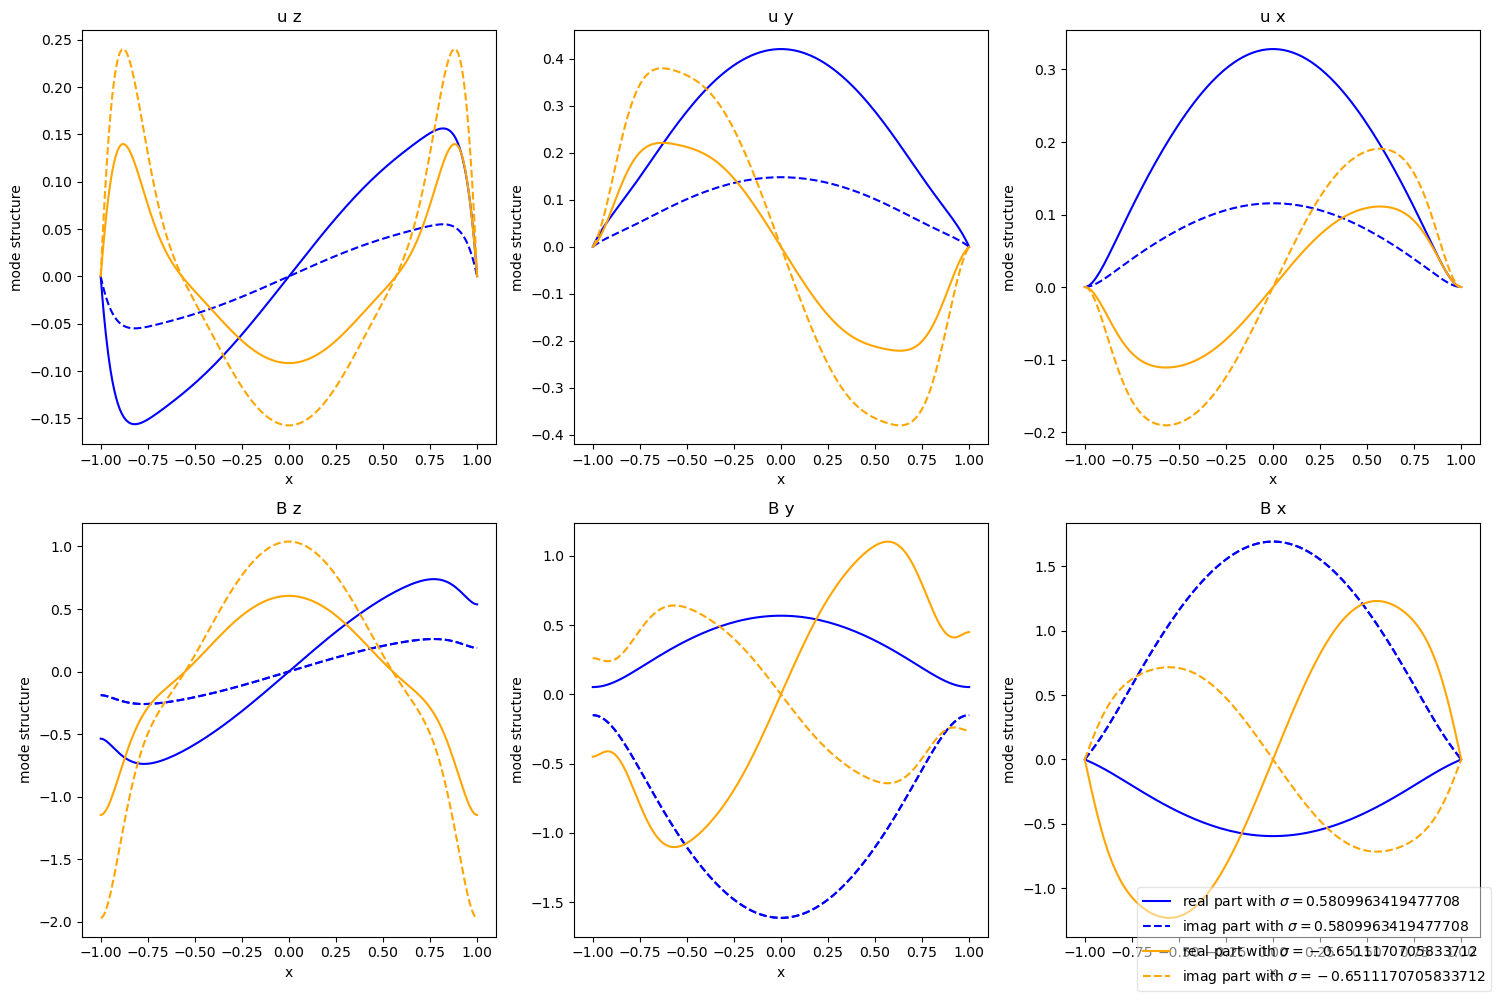

<Figure size 640x480 with 0 Axes>

In [3]:
#Plot right eigenmodes
stable_mode_idx = np.where(np.logical_and(np.abs(solver.eigenvalues.imag)<1e-10,\
                                           np.logical_and(solver.eigenvalues.real<-np.max(solver.eigenvalues.real)+1e-1,solver.eigenvalues.real>-np.max(solver.eigenvalues.real)-1e-1)))[0][0]
unstable_mode_idx = np.argsort(solver.eigenvalues.real)[-1]
x = dist.local_grid(xbasis)
fig = plt.figure(figsize=(15, 10))
axis_list = ['z','y','x']
ax = fig.add_subplot(2, 3, 0+1)  # 3 rows, 2 columns, i-th subplot
ax.set_title(f'u {axis_list[0]}') 
solver.set_state(unstable_mode_idx, 0)
ug_stable = u['g'][0,2,1,:]
print(solver.left_eigenvectors.shape)
print(solver.right_eigenvectors.shape)
print(u['g'].shape)
eigenvalue = solver.eigenvalues.real[unstable_mode_idx]
ax.plot(x[0,0,:], ug_stable.real, color='blue', label = f'real part with $\\sigma = {eigenvalue}$')
ax.plot(x[0,0,:], ug_stable.imag, '--',color = 'blue',label = f'imag part with $\\sigma = {eigenvalue}$')
# ax.plot(x[0,0,:], np.abs(ug_stable), '-.',color = 'blue',label = f'abs with $\\sigma = {eigenvalue}$')
solver.set_state(stable_mode_idx, 0)
ug_stable = u['g'][0,2,1,:]
eigenvalue = solver.eigenvalues.real[stable_mode_idx]
ax.plot(x[0,0,:], ug_stable.real, color='orange', label = f'real part with $\\sigma = {eigenvalue}$')
ax.plot(x[0,0,:], ug_stable.imag, '--',color = 'orange',label = f'imag part with $\\sigma = {eigenvalue}$')
# ax.plot(x[0,0,:], np.abs(ug_stable), '-.',color = 'orange',label = f'abs with $\\sigma = {eigenvalue}$')
ax.set_ylabel(r"mode structure")
ax.set_xlabel(r"x")

for i in range(1,3):
    axis_list = ['z','y','x']
    ax = fig.add_subplot(2, 3, i+1)  # 3 rows, 2 columns, i-th subplot
    ax.set_title(f'u {axis_list[i]}') 
    solver.set_state(np.argsort(solver.eigenvalues.real)[-1], 0)
    ug_stable = u['g'][i,1,1,:]
    eigenvalue = solver.eigenvalues.real[unstable_mode_idx]
    ax.plot(x[0,0,:], ug_stable.real, color='blue')
    ax.plot(x[0,0,:], ug_stable.imag, '--',color = 'blue')
    solver.set_state(stable_mode_idx, 0)
    ug_stable = u['g'][i,1,1,:]
    eigenvalue = solver.eigenvalues.real[stable_mode_idx]
    ax.plot(x[0,0,:], ug_stable.real, color='orange')
    ax.plot(x[0,0,:], ug_stable.imag, '--',color = 'orange')
    ax.set_ylabel(r"mode structure")
    ax.set_xlabel(r"x")

for i in range(0,3):
    axis_list = ['z','y','x']
    ax = fig.add_subplot(2, 3, i+4)  # 3 rows, 2 columns, i-th subplot
    ax.set_title(f'B {axis_list[i]}') 
    solver.set_state(unstable_mode_idx, 0)
    eigenvalue = solver.eigenvalues.real[unstable_mode_idx]
    bg_stable = b['g'][i,1,1,:]
    ax.plot(x[0,0,:], bg_stable.real, color = 'blue')
    ax.plot(x[0,0,:], bg_stable.imag, '--',color = 'blue')
    ax.plot(x[0,0,:], bg_stable.imag, '--',color = 'blue')
    solver.set_state(stable_mode_idx,0)
    eigenvalue = solver.eigenvalues.real[stable_mode_idx]
    bg_stable = b['g'][i,1,1,:]
    ax.plot(x[0,0,:], bg_stable.real, color = 'orange')
    ax.plot(x[0,0,:], bg_stable.imag, '--',color = 'orange')
    ax.set_ylabel(r"mode structure")
    ax.set_xlabel(r"x")
fig.legend(loc='lower right',framealpha=0.5)
plt.tight_layout()
plt.show()
# plt.savefig(f"mri_eigenmode_kz_{kz}_{Nx}_subplots.pdf")
plt.clf()

In [4]:
#This is now right the column vector are the eigenvectors
np.transpose(solver.modified_left_eigenvectors).conj()[292]@ np.transpose(solver.right_eigenvectors)[292]

(1.0000000000000004+4.440892098500626e-16j)

/home/hlu/miniconda3/envs/dedalus3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/hlu/miniconda3/envs/dedalus3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(2.982148897398215e-16+2.59165823838451e-16j)

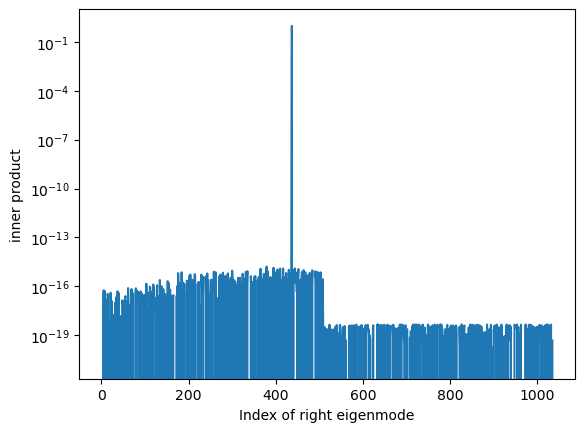

In [5]:
# test orthnormal of modified left and right eigenvectors
plt.semilogy(np.transpose(solver.modified_left_eigenvectors).conj()[stable_mode_idx]@solver.right_eigenvectors)
plt.xlabel("Index of right eigenmode")
plt.ylabel("inner product") 
np.transpose(solver.modified_left_eigenvectors).conj()[unstable_mode_idx]@np.transpose(solver.right_eigenvectors)[stable_mode_idx]

(1036, 1036)
(1036, 1036)
(3, 4, 4, 128)


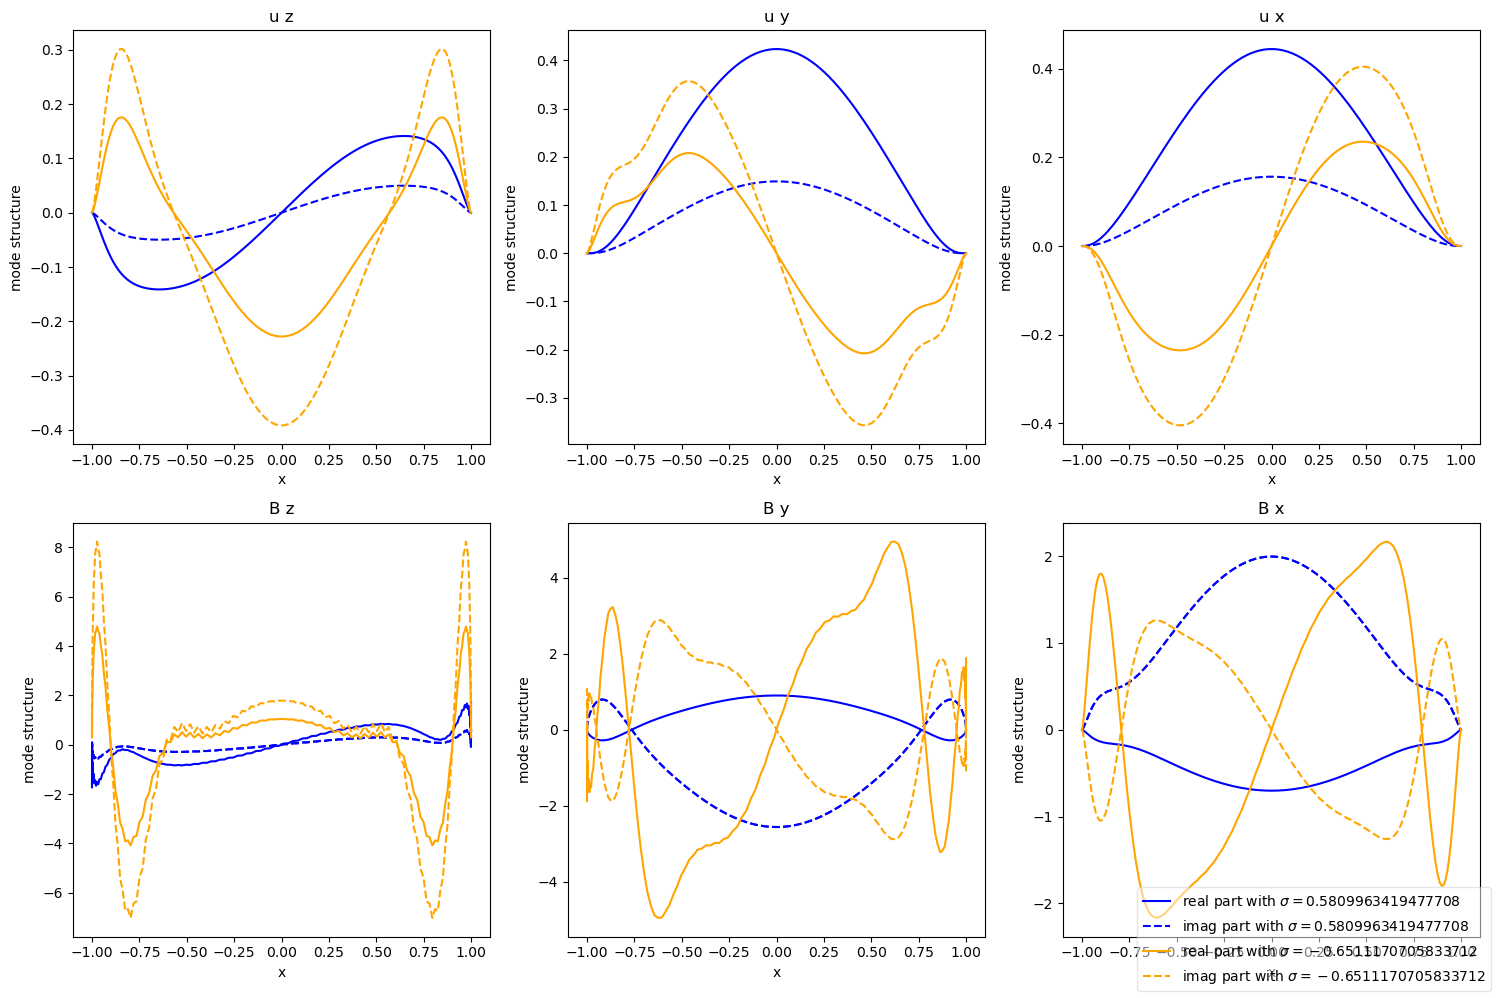

<Figure size 640x480 with 0 Axes>

In [6]:
#plot modified left eigenvectors using set_state_left
stable_mode_idx = np.where(np.logical_and(np.abs(solver.eigenvalues.imag)<1e-10,\
                                           np.logical_and(solver.eigenvalues.real<-np.max(solver.eigenvalues.real)+1e-1,solver.eigenvalues.real>-np.max(solver.eigenvalues.real)-1e-1)))[0][0]
unstable_mode_idx = np.argsort(solver.eigenvalues.real)[-1]
x = dist.local_grid(xbasis)
fig = plt.figure(figsize=(15, 10))
# for n, idx in enumerate(np.argsort(solver.eigenvalues)[:5], start=1):
#     solver.set_state(idx, 0)
#     ug_1_2 = np.abs(u['g'][2,1,1,:])
#     plt.plot(x[0,0,:], ug_1_2,label = f"growth rate = {solver.eigenvalues.real[np.argsort(solver.eigenvalues.real)[idx]]}")
axis_list = ['z','y','x']
ax = fig.add_subplot(2, 3, 0+1)  # 3 rows, 2 columns, i-th subplot
ax.set_title(f'u {axis_list[0]}') 
solver.set_state_left(unstable_mode_idx, 0)
ug_stable = u['g'][0,2,1,:]
print(solver.left_eigenvectors.shape)
print(solver.right_eigenvectors.shape)
print(u['g'].shape)
eigenvalue = solver.eigenvalues.real[unstable_mode_idx]
ax.plot(x[0,0,:], ug_stable.real, color='blue', label = f'real part with $\\sigma = {eigenvalue}$')
ax.plot(x[0,0,:], ug_stable.imag, '--',color = 'blue',label = f'imag part with $\\sigma = {eigenvalue}$')
# ax.plot(x[0,0,:], np.abs(ug_stable), '-.',color = 'blue',label = f'abs with $\\sigma = {eigenvalue}$')
solver.set_state_left(stable_mode_idx, 0)
ug_stable = u['g'][0,2,1,:]
eigenvalue = solver.eigenvalues.real[stable_mode_idx]
ax.plot(x[0,0,:], ug_stable.real, color='orange', label = f'real part with $\\sigma = {eigenvalue}$')
ax.plot(x[0,0,:], ug_stable.imag, '--',color = 'orange',label = f'imag part with $\\sigma = {eigenvalue}$')
# ax.plot(x[0,0,:], np.abs(ug_stable), '-.',color = 'orange',label = f'abs with $\\sigma = {eigenvalue}$')
ax.set_ylabel(r"mode structure")
ax.set_xlabel(r"x")

for i in range(1,3):
    axis_list = ['z','y','x']
    ax = fig.add_subplot(2, 3, i+1)  # 3 rows, 2 columns, i-th subplot
    ax.set_title(f'u {axis_list[i]}') 
    solver.set_state_left(np.argsort(solver.eigenvalues.real)[-1], 0)
    ug_stable = u['g'][i,1,1,:]
    eigenvalue = solver.eigenvalues.real[unstable_mode_idx]
    ax.plot(x[0,0,:], ug_stable.real, color='blue')
    ax.plot(x[0,0,:], ug_stable.imag, '--',color = 'blue')
    solver.set_state_left(stable_mode_idx, 0)
    ug_stable = u['g'][i,1,1,:]
    eigenvalue = solver.eigenvalues.real[stable_mode_idx]
    ax.plot(x[0,0,:], ug_stable.real, color='orange')
    ax.plot(x[0,0,:], ug_stable.imag, '--',color = 'orange')
    ax.set_ylabel(r"mode structure")
    ax.set_xlabel(r"x")

for i in range(0,3):
    axis_list = ['z','y','x']
    ax = fig.add_subplot(2, 3, i+4)  # 3 rows, 2 columns, i-th subplot
    ax.set_title(f'B {axis_list[i]}') 
    solver.set_state_left(unstable_mode_idx, 0)
    eigenvalue = solver.eigenvalues.real[unstable_mode_idx]
    bg_stable = b['g'][i,1,1,:]
    ax.plot(x[0,0,:], bg_stable.real, color = 'blue')
    ax.plot(x[0,0,:], bg_stable.imag, '--',color = 'blue')
    ax.plot(x[0,0,:], bg_stable.imag, '--',color = 'blue')
    solver.set_state_left(stable_mode_idx,0)
    eigenvalue = solver.eigenvalues.real[stable_mode_idx]
    bg_stable = b['g'][i,1,1,:]
    ax.plot(x[0,0,:], bg_stable.real, color = 'orange')
    ax.plot(x[0,0,:], bg_stable.imag, '--',color = 'orange')
    ax.set_ylabel(r"mode structure")
    ax.set_xlabel(r"x")
fig.legend(loc='lower right',framealpha=0.5)
plt.tight_layout()
plt.show()
# plt.savefig(f"mri_eigenmode_kz_{kz}_{Nx}_subplots.pdf")
plt.clf()

In [7]:
# Build Fourier basis for x, y with prescribed kx, ky as the fundamental modes
Nx_ivp = 128
Ny_ivp = 4
Nz_ivp = 4
# Bases
coords = d3.CartesianCoordinates('z', 'y', 'x')
dist_ivp = d3.Distributor(coords, dtype=np.complex128)
xbasis_ivp = d3.ChebyshevT(coords['x'], size=Nx_ivp, bounds=(-Lx, Lx))
ybasis_ivp = d3.RealFourier(coords['y'], size=Ny_ivp, bounds=(0, Ly))
zbasis_ivp = d3.RealFourier(coords['z'], size=Nz_ivp, bounds=(0, Lz))

z_ivp, y_ivp, x_ivp = dist_ivp.local_grids(zbasis_ivp, ybasis_ivp, xbasis_ivp)


# Fields
bases_ivp = (zbasis_ivp, ybasis_ivp, xbasis_ivp)
# 

In [25]:
a_stable = dist_ivp.VectorField(coords, name='a_stable', bases=bases_ivp)
a_unstable = dist_ivp.VectorField(coords, name='a_unstable', bases=bases_ivp)
u_stable = dist_ivp.VectorField(coords, name='u_stable', bases=bases_ivp)
u_unstable = dist_ivp.VectorField(coords, name='u_unstable', bases=bases_ivp)
p_stable = dist_ivp.Field(name='p_stable', bases=bases_ivp)
p_unstable = dist_ivp.Field(name='p_unstable', bases=bases_ivp)
phi_stable = dist_ivp.Field(name='phi_stable', bases=bases_ivp)
phi_unstable = dist_ivp.Field(name='phi_unstable', bases=bases_ivp)
tau_p_stable = dist_ivp.Field(name='tau_p')
tau_p_unstable = dist_ivp.Field(name='tau_p')
tau_phi_stable = dist_ivp.Field(name='tau_phi')
tau_phi_unstable = dist_ivp.Field(name='tau_phi')
tau_a1_stable = dist_ivp.VectorField(coords, name='tau_a1', bases=(zbasis_ivp, ybasis_ivp))
tau_a1_unstable = dist_ivp.VectorField(coords, name='tau_a1', bases=(zbasis_ivp, ybasis_ivp))
tau_a2_stable = dist_ivp.VectorField(coords, name='tau_a2', bases=(zbasis_ivp, ybasis_ivp))
tau_a2_unstable = dist_ivp.VectorField(coords, name='tau_a2', bases=(zbasis_ivp, ybasis_ivp))
tau_u1_stable = dist_ivp.VectorField(coords, name='tau_u1', bases=(zbasis_ivp, ybasis_ivp))
tau_u1_unstable = dist_ivp.VectorField(coords, name='tau_u1', bases=(zbasis_ivp, ybasis_ivp))
tau_u2_stable = dist_ivp.VectorField(coords, name='tau_u2', bases=(zbasis_ivp, ybasis_ivp))
tau_u2_unstable = dist_ivp.VectorField(coords, name='tau_u2', bases=(zbasis_ivp, ybasis_ivp))

In [34]:
solver.set_state_left(unstable_mode_idx,0)
a_stable['c']=a['c'].copy()
u_stable['c']=u['c'].copy()
p_stable['c']=p['c'].copy()
phi_stable['c']=phi['c'].copy()
solver.set_state(stable_mode_idx,0)
a_unstable['c']=a['c'].copy()
u_unstable['c']=u['c'].copy()
p_unstable['c']=p['c'].copy()
phi_unstable['c']=phi['c'].copy()

In [35]:
#The tau terms do not affect the value of inner product
(a_stable['c'].conj()*a_unstable['c']).sum()+(u_unstable['c']*u_stable['c'].conj()).sum()+(p_unstable['c']*p_stable['c'].conj()).sum()+(phi_unstable['c']*phi_stable['c'].conj()).sum()\
    # +(tau_a1_unstable['c']*tau_a1_stable['c'].conj()).sum()+(tau_a2_unstable['c']*tau_a2_stable['c'].conj()).sum()+(tau_u1_unstable['c']*tau_u1_stable['c'].conj()).sum()+(tau_u2_unstable['c']*tau_u2_stable['c'].conj()).sum()+\
    # (tau_p_unstable['c']*tau_p_stable['c'].conj()).sum()+(tau_phi_unstable['c']*tau_phi_stable['c'].conj()).sum()

(2.9821573677276877e-16+2.59165823838451e-16j)

In [36]:
solver.set_state_left(unstable_mode_idx,0)
a_stable['g']=a['g'].copy()
u_stable['g']=u['g'].copy()
p_stable['g']=p['g'].copy()
phi_stable['g']=phi['g'].copy()
tau_u1_stable['g'] = tau_u1['g'].copy()
tau_u2_stable['g'] = tau_u2['g'].copy()
tau_a1_stable['g'] = tau_a1['g'].copy()
tau_a2_stable['g'] = tau_a2['g'].copy()
tau_p_stable['g'] = tau_p['g'].copy()
tau_phi_stable['g'] = tau_phi['g'].copy()
solver.set_state(unstable_mode_idx,0)
a_unstable['g']=a['g'].copy()
u_unstable['g']=u['g'].copy()
p_unstable['g']=p['g'].copy()
phi_unstable['g']=phi['g'].copy()
tau_u1_unstable['g'] = tau_u1['g'].copy()
tau_u2_unstable['g'] = tau_u2['g'].copy()
tau_a1_unstable['g'] = tau_a1['g'].copy()
tau_a2_unstable['g'] = tau_a2['g'].copy()
tau_p_unstable['g'] = tau_p['g'].copy()
tau_phi_unstable['g'] = tau_phi['g'].copy()

In [37]:
#The tau terms do not affect the value of inner product
(a_stable['c'].conj()*a_unstable['c']).sum()+(u_unstable['c']*u_stable['c'].conj()).sum()+(p_unstable['c']*p_stable['c'].conj()).sum()+(phi_unstable['c']*phi_stable['c'].conj()).sum()\
    # +(tau_a1_unstable['c']*tau_a1_stable['c'].conj()).sum()+(tau_a2_unstable['c']*tau_a2_stable['c'].conj()).sum()+(tau_u1_unstable['c']*tau_u1_stable['c'].conj()).sum()+(tau_u2_unstable['c']*tau_u2_stable['c'].conj()).sum()+\
    # (tau_p_unstable['c']*tau_p_stable['c'].conj()).sum()+(tau_phi_unstable['c']*tau_phi_stable['c'].conj()).sum()

(651.8986469044038-7.481122045092069e-15j)